<a href="https://colab.research.google.com/github/FGalvao77/Classificador-de-Fake-News-com-Keras-e-spaCy/blob/main/Classificador_de_Fake_News_com_Keras_e_spaCy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Classificador de `Fake News` com _Keras_ e _spaCy_**
---
---

In [1]:
# instalando a biblioteca "kaggle"
%%capture
!pip install kaggle

In [2]:
# importando a chave da API do Kaggle
import time                      
from google.colab import files 

uploaded = files.upload()
time.sleep(10)

Saving kaggle.json to kaggle.json


In [3]:
# criando diretório e realizando o download do dataset
%mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d antonioskokiantonis/newscsv --force

 79% 9.00M/11.5M [00:01<00:00, 8.42MB/s]
100% 11.5M/11.5M [00:01<00:00, 7.38MB/s]


In [4]:
# descompactando o arquivo zipado
%%capture
!unzip /content/newscsv.zip

In [5]:
# removendo o arquivo zipado do ambiente
%rm -rf newscsv.zip

In [6]:
# importando as bibliotecas iniciais
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [7]:
# carregando o dataset no objeto "data"
data = pd.read_csv('news.csv')

# visualizando as 5 primeiras observações do conjunto de dados
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [8]:
# resetando e definindo o índice na coluna "0"
data = pd.read_csv('news.csv', index_col=0).reset_index()

# visualizando novamente as 5 primeiras observações do conjunto de dados
data.head() 

,index,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [9]:
# excluindo a coluna "index"
data.drop(labels=['index'], axis=1, inplace=True)

# visualizando as 5 primeiras observações do conjunto de dados
data.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [10]:
# visualizando informações gerais
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


In [11]:
# contabilizando a quantidade de observações em cada rótulo
data['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [12]:
# estatística da coluna "text"
txt_length = data.text.str.split().str.len()

pd.DataFrame(txt_length.describe()).T

,count,mean,std,min,25%,50%,75%,max
text,6335.0,776.30071,854.333358,0.0,289.0,597.0,1024.0,20891.0


In [13]:
# estatística da coluna "title"
title_length = data.title.str.split().str.len()

pd.DataFrame(title_length.describe()).T

,count,mean,std,min,25%,50%,75%,max
title,6335.0,10.496448,3.985165,1.0,8.0,10.0,13.0,53.0


In [14]:
# importando função para realizar a transformação do rótulo categórico para numérico
from sklearn.preprocessing import LabelEncoder

In [15]:
# instanciando o objeto
le = LabelEncoder()

# aplicando o objeto na "feature" de interesse, nesse caso a "label"
data['label'] = le.fit_transform(data['label'])

In [16]:
# visualizando os valores únicos presente no atributo alvo
data['label'].unique()

array([0, 1])

In [17]:
# visualizando valores nulos/ausentes
data.isna().sum()

title    0
text     0
label    0
dtype: int64

In [18]:
# importando as bibliotecas e as funções/módulos para construção e avaliação do modelo
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [19]:
compile_hp = dict()

compile_hp['loss'] = 'binary_crossentropy'
compile_hp['optimizer'] = Adam(learning_rate=0.001)
compile_hp['metrics'] = ['accuracy']
compile_hp['maxlen'] = 500

# ajustando hiperparâmetros
fit_hp = dict()

fit_hp['batch_size'] = 64
fit_hp['epochs'] = 100
fit_hp['validation_split'] = 0.3

# criando o "callback" para selecionar o melhor modelo
fit_hp['callbacks'] = EarlyStopping(monitor='val_loss',
                                    mode='min',
                                    restore_best_weights = True,
                                    patience=10)

# eliminnado o "verbose" para ter um notebook mais organizado
fit_hp['verbose'] = 0

In [20]:
def tokenize_padder(train_text, test_text,
                    chars_to_filter='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                    oov_token='OOV', maxlen=500, 
                    padding='pre', truncating='post'):
    
    # criando o objeto "tokenizer"
    tokenizer = Tokenizer(filters=chars_to_filter,
                          oov_token=oov_token)

    # ajustando (treinando) o tokenizador apenas aos dados de treinamento
    tokenizer.fit_on_texts(train_text)

    # gerando sequências dos dados: treino e teste
    train_sequences = tokenizer.texts_to_sequences(train_text)
    test_sequences = tokenizer.texts_to_sequences(test_text)

    # utilizando o módulo/função "pad_sequences" para instanciar os dados de treino e teste
    # o pré-preenchimento é empiricamente melhor para modelagem de sequência
    # o pós-truncamento garante que os títulos sejam incluídos nas observações
    train_padded = pad_sequences(train_sequences, maxlen=maxlen, 
                                 padding=padding, truncating=truncating)
    test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding=padding, 
                                truncating=truncating)

    return tokenizer, train_padded, test_padded

In [21]:
# instanciando os dados da variável explicativa (X) e da variável resposta (y)
X = data.text.values
y = np.array(data['label'], dtype='float32')

In [23]:
# separando os dados de treino e teste
text_train, text_test, y_train, y_test = train_test_split(X, y, 
                                                          test_size=0.3, 
                                                          shuffle=True,
                                                          random_state=1522)

# utilizando a função "tokenize_padder" para realizar 
# o processamento, tokenização e pad dos dados de "text_train" e "text_test"
tokenizer, X_train, X_test = tokenize_padder(text_train, text_test)

In [24]:
# importando a bibliteca e os módulos/funções
import spacy

from keras.initializers import Constant
from keras.layers import Embedding

In [25]:
def spacy_embedding(tokenizer, maxlen=500, show_progress=False):

    # carregando o pipeline "spacy"
    nlp = spacy.load('en_core_web_sm')
    # obtendo o tamanho do vocabulário do tokenizer
    vocab_size = len(tokenizer.word_index) + 1
    # obtendo o número de dimensões de incorporação que o SpaCy usa
    embedding_dim = nlp('any_word').vector.shape[0]
    # criando uma matriz para usar na camada de incorporação (embedding layer)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # iterando através do nosso vocabulário, mapeando palavras para incorporação ao espacial (spacy embedding )
    # OBS: isso vai demorar um pouco para executar
    for i, word in enumerate(tokenizer.word_index):
        embedding_matrix[i] = nlp(word).vector
        # mostrando o progresso, se desejado
        if show_progress:
            if i % 10000 == 0 and i > 0:
                print(f'[COMPLETE]: {round(i*100/vocab_size, 2)}%')


    # carregando a matriz de incorporação (embedding matrix) como a matriz de pesos para a camada de incorporação (embedding layer)
    # definindo o treinável como Falso, pois a camada já está "aprendida"
    Embedding_layer = Embedding(
        vocab_size,
        embedding_dim,
        input_length=maxlen,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False,
        name='spacy_embedding')

    return Embedding_layer

In [26]:
def keras_embedding(tokenizer, embedding_dim=256, maxlen=500):

    # obtendo o tamanho do vocabulário do tokenizer
    vocab_size = len(tokenizer.word_index) + 1

    # carregando a matriz de incorporação (embedding matrix) como a matriz de pesos para a camada de incorporação (embedding layer)
    # definindo o treinável como Falso, pois a camada já está "aprendida"
    Embedding_layer = Embedding(
        vocab_size,
        embedding_dim,
        input_length=maxlen,
        name='keras_embedding')

    return Embedding_layer

In [27]:
# gerar as incorporações (the embeddings)
embed_dict = dict()

embed_dict['spacy'] = spacy_embedding(tokenizer, show_progress=True, maxlen=500)
embed_dict['keras'] = keras_embedding(tokenizer, maxlen=500)

[COMPLETE]: 11.98%
[COMPLETE]: 23.96%
[COMPLETE]: 35.94%
[COMPLETE]: 47.93%
[COMPLETE]: 59.91%
[COMPLETE]: 71.89%
[COMPLETE]: 83.87%
[COMPLETE]: 95.85%


In [28]:
from keras.layers import Dense, BatchNormalization, Reshape, Activation
from keras.layers import Embedding, GRU, Bidirectional
from keras import Sequential

In [29]:
def bi_gru(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], 
           batch_normalize=False, embedding=None, maxlen=500, 
           hidden_dense_units=256, dense_kernel_initializer='glorot_uniform',
           rnn_units=32, rnn_kernel_initializer='glorot_uniform'):

    # construindo o modelo
    model = Sequential(name='GRU')

    # adicione incorporação (embedding), se desejar
    if embedding:
        # "embedding" contém forma de entrada
        model.add(embedding)
    else:
        # caso contrário, remodele os dados para trabalhar com GRU
        model.add(Reshape((maxlen, 1), input_shape=(maxlen, ), 
                          name='Reshaping'))

    # adicionar GRU
    model.add(Bidirectional(GRU(rnn_units, 
                                kernel_initializer=rnn_kernel_initializer),
                                name='Bidirectional_GRU'))

    # modelo base (baseline model)
    model.add(Dense(hidden_dense_units, name='Linear_Dense',
                    kernel_initializer=dense_kernel_initializer))

    # modelo normalizado em lote (batch normalised)
    if batch_normalize:
        model.add(BatchNormalization(name='Batch_Norm1'))

    # aplicando ativação não linear, especificada desta forma para ser consistente
    # com o papel original (original paper)
    model.add(Activation('relu', name='ReLU_Activation'))

    # camada de saída (output layer)
    model.add(Dense(1, activation='sigmoid', name='Output',
                    kernel_initializer=dense_kernel_initializer))
    # compilação do modelo (compile model)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [30]:
def pred_labels(model, X_test):

    # realizando as previsões (make predictions) / obtendo as probabilidades brutas (get raw probabilities)
    raw_preds = model.predict(X_test)

    # convertendo as probabilidades em rótulos
    preds = (raw_preds > 0.5).astype(int).reshape(-1)

    return preds

In [31]:
from sklearn.metrics import f1_score, roc_auc_score

In [32]:
def get_test_metrics(model, X_test, y_test, history, embedding=None, 
                     batch_normalize=False, verbose=0):
    n_epochs = len(history.history['loss'])

    # obtendo a acurácia do teste
    test_acc = model.evaluate(X_test, y_test, verbose=verbose)[1]

    # obtendo as previsões (get raw predictions) / probabilidades brutas para ROC AUC (probabilities for ROC AUC)
    probs = model.predict(X_test)
    test_roc_auc = roc_auc_score(y_test, probs)

    # obtendo as previsões de rótulos para F1
    preds = pred_labels(model, X_test)
    test_f1 = f1_score(y_test, preds)

    # salvando os resultados em um "data frame"
    results = pd.DataFrame({'embedding': embedding,
                            'batch_normalize': batch_normalize,
                            'accuracy': test_acc,
                            'roc_auc': test_roc_auc, 
                            'f1': test_f1,
                            'epochs': n_epochs}, index=[0])

    return results

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style='ticks', palette='pastel')
plt.style.use('ggplot')

In [34]:
def plot_loss(history, xlabel='Epochs', ylabel='Loss', title='Loss VS Epochs', 
              ylim_top=None, metric='loss', metric2='val_loss', 
              metric_label='Training Loss', metric2_label='Validation Loss'):
    """
    Função para plotar a perda (loss) do modelo.
    Toma o histórico, uma instância do histórico do modelo e,
    exibe o gráfico embutido
    """
    # mostrando a perda de treinamento e validação VS épocas
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(history.history[metric], label=metric_label, lw=3)
    # adicionando um controle, se você quiser apenas plotar uma métrica
    if metric2:
        ax.plot(history.history[metric2], label=metric2_label, lw=3)
        ax.legend()
    # adicionando títulos
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(top=ylim_top)

In [35]:
def plot_acc(history, xlabel='Epochs', ylabel='Accuracy', title='Accuracy VS Epochs', 
             ylim_top=None, metric='accuracy', metric2='val_accuracy', 
             metric_label='Training Accuracy', metric2_label='Validation Accuracy'):
    """
    Função para plotar a precisão do modelo.
    Toma o histórico, uma instância do histórico do modelo e,
    exibe o gráfico embutido
    """
    # mostrando a perda de treinamento e validação VS épocas
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(history.history[metric], label=metric_label, lw=3, color='lightgreen')
    # adicionando um controle, se você quiser apenas plotar uma métrica
    if metric2:
        ax.plot(history.history[metric2], label=metric2_label, lw=3, color='green')
        ax.legend()
    # adicionando títulos
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(top=ylim_top)

In [36]:
# criando um "data frame" para armazenar os resultados de cada modelo no conjunto de teste
all_results = pd.DataFrame()

In [37]:
# definindo o "embedding"
embedding_layer = 'keras'
# alternando a normalização em lote (batch normalization)
batch_normalize = True

# construindo e ajustando o modelo com "embedding"
model_keras = bi_gru(**compile_hp, batch_normalize=batch_normalize,
                  embedding=embed_dict[embedding_layer])

# visualizando o sumário do modelo
model_keras.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_embedding (Embedding)  (None, 500, 256)         21366528  
                                                                 
 Bidirectional_GRU (Bidirect  (None, 64)               55680     
 ional)                                                          
                                                                 
 Linear_Dense (Dense)        (None, 256)               16640     
                                                                 
 Batch_Norm1 (BatchNormaliza  (None, 256)              1024      
 tion)                                                           
                                                                 
 ReLU_Activation (Activation  (None, 256)              0         
 )                                                               
                                                               

In [38]:
# realizando o treinamento do modelo "model_keras"
history_keras = model_keras.fit(X_train, y_train, epochs=30, verbose=1, 
                                validation_data=(X_test, y_test))

Epoch 1/30
139/139 [==============================] - 13s 46ms/step - loss: 0.4476 - accuracy: 0.7824 - val_loss: 0.6390 - val_accuracy: 0.5187
Epoch 2/30
139/139 [==============================] - 6s 41ms/step - loss: 0.0964 - accuracy: 0.9664 - val_loss: 0.3823 - val_accuracy: 0.8474
Epoch 3/30
139/139 [==============================] - 6s 41ms/step - loss: 0.0260 - accuracy: 0.9928 - val_loss: 0.2906 - val_accuracy: 0.8759
Epoch 4/30
139/139 [==============================] - 6s 41ms/step - loss: 0.0109 - accuracy: 0.9968 - val_loss: 0.4142 - val_accuracy: 0.8653
Epoch 5/30
139/139 [==============================] - 6s 44ms/step - loss: 0.0031 - accuracy: 0.9998 - val_loss: 0.4194 - val_accuracy: 0.8790
Epoch 6/30
139/139 [==============================] - 6s 42ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.4518 - val_accuracy: 0.8769
Epoch 7/30
139/139 [==============================] - 6s 46ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.5965 - val_accuracy: 0.859

In [39]:
# visualizando as chaves presente no objeto "history_keras"
history_keras.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

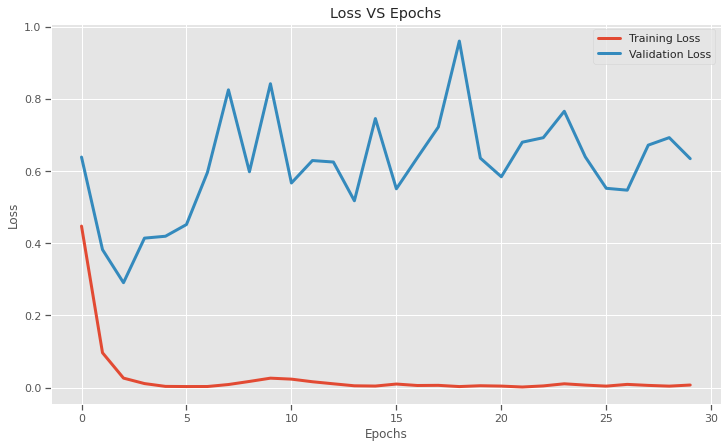

In [40]:
# com a função "plot_loss()", plotando o gráfico de perda do modelo
plot_loss(history_keras)

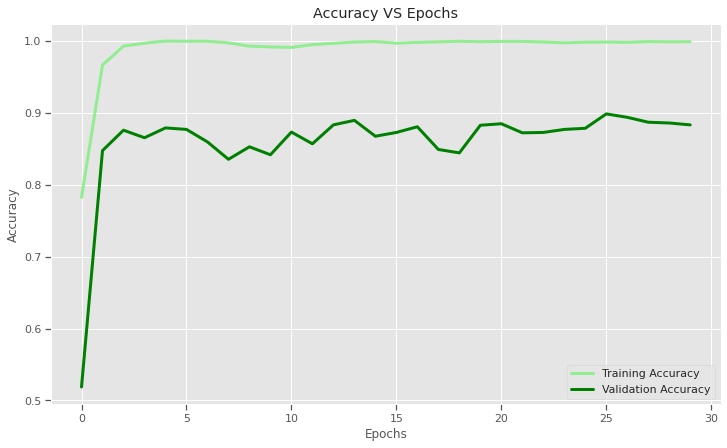

In [41]:
# com a função "plot_acc()", plotando o gráfico da acurácia do modelo
plot_acc(history_keras)

In [43]:
# com a função "get_test_metrics", calculando as métricas do modelo
results_keras = get_test_metrics(model_keras, X_test, y_test,
                                 history_keras, embedding=embedding_layer,
                                 batch_normalize=batch_normalize)

# concatenando todos os resultados
all_results = pd.concat([all_results, results_keras])

60/60 [==============================] - 1s 11ms/step


In [45]:
# definindo o "embedding"
embedding_layer = 'spacy'
# alternando a normalização em lote (batch normalization)
batch_normalize = True

# construindo e ajustando o modelo com "embedding"
model_spacy = bi_gru(**compile_hp, batch_normalize=batch_normalize,
                     embedding=embed_dict[embedding_layer])

# visualizando o sumário do modelo
model_spacy.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spacy_embedding (Embedding)  (None, 500, 96)          8012448   
                                                                 
 Bidirectional_GRU (Bidirect  (None, 64)               24960     
 ional)                                                          
                                                                 
 Linear_Dense (Dense)        (None, 256)               16640     
                                                                 
 Batch_Norm1 (BatchNormaliza  (None, 256)              1024      
 tion)                                                           
                                                                 
 ReLU_Activation (Activation  (None, 256)              0         
 )                                                               
                                                               

In [46]:
# realizando o treinamento do modelo "model_spacy"
history_spacy = model_spacy.fit(X_train, y_train, epochs=30, verbose=1, 
                                validation_data=(X_test, y_test))

Epoch 1/30
139/139 [==============================] - 9s 43ms/step - loss: 0.5905 - accuracy: 0.7018 - val_loss: 0.5273 - val_accuracy: 0.7380
Epoch 2/30
139/139 [==============================] - 4s 29ms/step - loss: 0.3864 - accuracy: 0.8257 - val_loss: 0.4988 - val_accuracy: 0.7712
Epoch 3/30
139/139 [==============================] - 4s 28ms/step - loss: 0.2678 - accuracy: 0.8933 - val_loss: 0.4187 - val_accuracy: 0.8243
Epoch 4/30
139/139 [==============================] - 4s 28ms/step - loss: 0.1836 - accuracy: 0.9285 - val_loss: 0.3723 - val_accuracy: 0.8527
Epoch 5/30
139/139 [==============================] - 4s 28ms/step - loss: 0.1352 - accuracy: 0.9481 - val_loss: 0.3818 - val_accuracy: 0.8653
Epoch 6/30
139/139 [==============================] - 4s 31ms/step - loss: 0.0905 - accuracy: 0.9653 - val_loss: 0.4346 - val_accuracy: 0.8590
Epoch 7/30
139/139 [==============================] - 6s 41ms/step - loss: 0.0591 - accuracy: 0.9808 - val_loss: 0.5616 - val_accuracy: 0.8517

In [47]:
# visualizando as chaves presente no objeto "history_spacy"
history_spacy.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

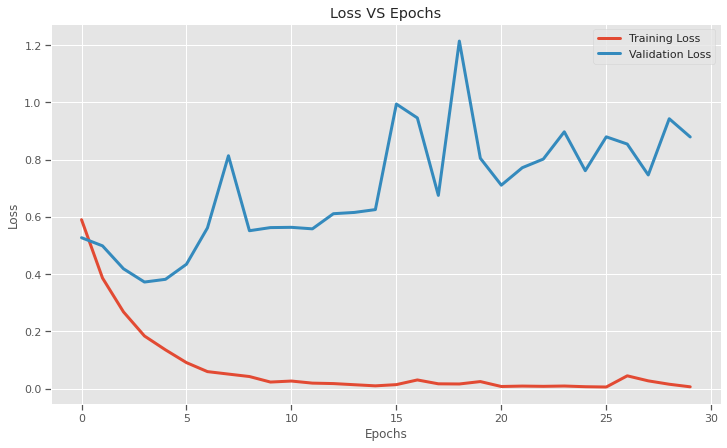

In [48]:
# com a função "plot_loss()", plotando o gráfico de perda do modelo
plot_loss(history_spacy)

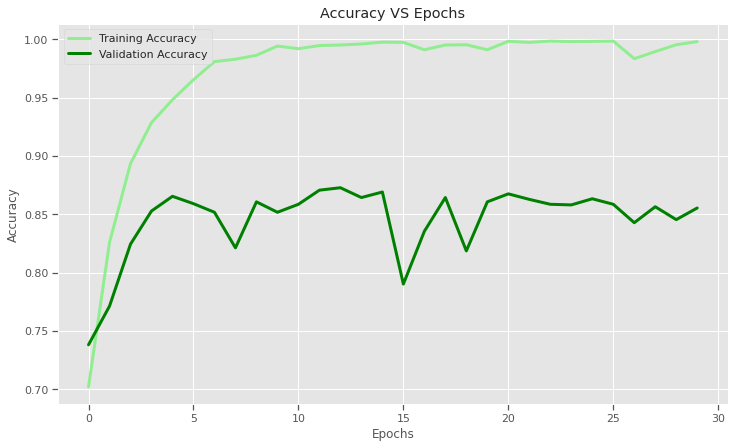

In [49]:
# com a função "plot_acc()", plotando o gráfico da acurácia do modelo
plot_acc(history_spacy)

In [50]:
# com a função "get_test_metrics", calculando as métricas do modelo
results_spacy = get_test_metrics(model_spacy, X_test, y_test,
                                 history_spacy, embedding=embedding_layer,
                                 batch_normalize=batch_normalize)

# concatenando todos os resultados
all_results = pd.concat([all_results, results_spacy])

60/60 [==============================] - 1s 17ms/step


In [51]:
# viualizando os resultados dos modelos
all_results

,embedding,batch_normalize,accuracy,roc_auc,f1,epochs
0,keras,True,0.883219,0.953371,0.882664,30
0,keras,True,0.883219,0.953371,0.882664,30
0,spacy,True,0.855339,0.936923,0.864599,30
